In [3]:
import pandas as pd
import numpy as np
import warnings
import scipy
import matplotlib.pyplot as plt
from safeaipackage import check_accuracy, check_robustness, check_explainability, check_fairness, check_privacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 10000)

In [4]:
data = pd.read_excel("D:/files/research_activities/ORGANIZED_FILES/safeaipackage/examples/employee.xlsx")
print("This dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

This dataset has 473 rows and 9 columns


,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat
0,57000,36,15,27000,98,144,no_min,m,manager
1,40200,30,16,18750,98,36,no_min,m,Clerical
2,21450,59,12,12000,98,381,no_min,f,Clerical
3,21900,41,8,13200,98,190,no_min,f,Clerical
4,45000,33,15,21000,98,138,no_min,m,Clerical


In [5]:
data["gender"] = np.where(data["gender"]=="m", 0, 1)
data["minority"] = np.where(data["minority"]=="no_min", 0, 1)
data = pd.get_dummies(data, columns=["jobcat"])
data.head()

,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager
0,57000,36,15,27000,98,144,0,0,0,0,1
1,40200,30,16,18750,98,36,0,0,1,0,0
2,21450,59,12,12000,98,381,0,1,1,0,0
3,21900,41,8,13200,98,190,0,1,1,0,0
4,45000,33,15,21000,98,138,0,0,1,0,0


In [6]:
data["promoted"] = np.where(data["salary"]/data["startsal"] > 2,1,0)

data["promoted"].value_counts()

0    253
1    220
Name: promoted, dtype: int64

In [7]:
X = data.drop(["promoted", "salary", "startsal"], axis=1)
y = data["promoted"]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

print(xtrain.shape)
print(xtest.shape)

(331, 9)
(142, 9)


In [8]:
rf_model_full = RandomForestClassifier(random_state=1).fit(xtrain, ytrain)

rf_predictions_full = rf_model_full.predict(xtest)
rf_predictions_full

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

# ACCURACY

## To check accuracy of the model trained to predict if an employee will be promoted or not, we can use the RGA function defined in the "check_accuracy" module of "safeaipackage" python package

In [9]:
#ACCURACY

rga_full = check_accuracy.rga(ytest, rf_predictions_full)
rga_full

0.6848958333333334

### The higher RGA value (closer to one) the better concordance between the trained model and the actual values

In [10]:
rga_pvalues = []
for i in xtrain.columns:
    xtrain_rm = xtrain.drop(i, axis=1)
    xtest_rm = xtest.drop(i, axis=1)
    model_rm = rf_model_full.fit(xtrain_rm, ytrain)
    yhat_rm = model_rm.predict(xtest_rm)
    rga_pvalues.append(check_accuracy.rga_statistic_test(ytest, yhat_rm, rf_predictions_full))
print(pd.DataFrame(rga_pvalues, index=xtest.columns, columns=["P_value"]))

                   P_value
age               0.425752
edu               0.383272
jobtime           0.563593
prevexp           0.455730
minority          0.353790
gender            0.665772
jobcat_Clerical   0.297502
jobcat_Custodial  0.442390
jobcat_manager    0.079890


# EXPLAINABILITY

# To find the contribution of explanatory variables to the output of the model, we can use the RGE function defined in the "check_explainability" module of "safeaipackage" python package

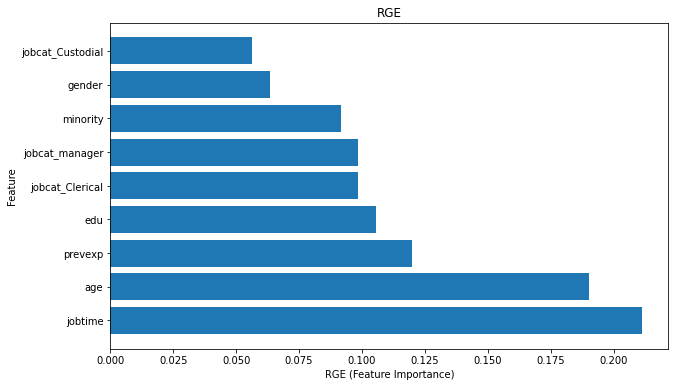

,RGE
jobtime,0.211268
age,0.190141
prevexp,0.119718
edu,0.105634
jobcat_Clerical,0.098592
jobcat_manager,0.098592
minority,0.091549
gender,0.063380
jobcat_Custodial,0.056338


In [12]:
check_explainability.rge(xtrain, xtest, ytrain, ytest, rf_model_full)

# ROBUSTNESS

In [12]:
features_tobe_perturbed = ['age', 'edu', 'jobtime', 'prevexp', 'minority','gender', 'jobcat_Clerical', 
                           'jobcat_Custodial', 'jobcat_manager']
rgr_values = []
for i in features_tobe_perturbed:
    data_ = data
    rgr_ = []
    for n in range(10):
        data_[i] = np.random.permutation(data_[i])
        X = data_.drop(["promoted"], axis=1)
        y = data_["promoted"]
        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)
        rf_perturbed = RandomForestClassifier(random_state=1).fit(xtrain, ytrain)
        rf_predictions_perturbed = rf_perturbed.predict(xtest)
        rgr_.append(check_robustness.rgr(rf_predictions_full, rf_predictions_perturbed))
    rgr_values.append(np.mean(rgr_))
pd.DataFrame(rgr_values, index=features_tobe_perturbed, columns=["RGR"])

,RGR
age,0.748592
edu,0.746479
jobtime,0.706338
prevexp,0.666197
minority,0.678169
gender,0.677465
jobcat_Clerical,0.673944
jobcat_Custodial,0.663380
jobcat_manager,0.680282


In [ ]:
check_robustness.rgr(xtrain, xtest, ytrain)

# FAIRNESS

In [40]:
check_fairness.rgf(rf_predictions_gender, rf_predictions_full)

0.06259936406995215